# La différentiation automatique et un début de *deep learning*

Quelques liens pour aller plus loin :
* [Autodiff](https://github.com/maximiliense/lmpirp/blob/main/Notes/Automatic_differentiation.pdf)

## Introduction

Comme vu précédemment, un grand nombre de modèles de *machine learning* s'appuient sur des algorithmes d'optimisation de type "descente de gradient". Ces algorithmes requièrent le calcul du gradient à chaque itération. Nous avons pu voir pour la régression linéaire et la régression logistique que cela était assez fastidieux. Ainsi, en pratique, on ne se sert que de modèles déjà codés et où il n'est pas nécessaire de fournir le gradient.

Le *deep learning*, à l'inverse, s'appuie sur une quantité incroyable de modèles, customisés à la moindre occasion. Le *deep learning* n'échappe pas à la règle et est également optimisé au travers d'algorithmes d'optimisation de type "descente de gradient". Heureusement, il n'est pas nécessaire de calculer le gradient à la main de ces fonctions immenses. Les *frameworks* de *deep learning* sont en effet avant tout des *frameworks* de différentiation automatique.

## Premiers tests avec Pytorch

In [1]:
import torch

<span style="color:blue">**Exercice 1 :**</span> **Commençons simple. Soit la fonction suivante :
\begin{equation}
f(x)=3x+5
\end{equation}
Calculer $\frac{\partial f}{\partial x}(0)$ à la main et via *torch*.**

In [2]:
####### Complete this part ######## or die ####################
def f(x):
    return 3*x+5

x = torch.tensor(0., requires_grad=True)

f(x).backward()
###############################################################
print('La derivee en 0 de f est', float(x.grad))

La derivee en 0 de f est 3.0


<span style="color:blue">**Exercice 2 :**</span> **Un tout petit peu plus compliqué. Soit la fonction suivante :
\begin{equation}
f(x)=2^x
\end{equation}
Calculer $\frac{\partial f}{\partial x}(0)$  et $\frac{\partial f}{\partial x}(1)$ à la main et via *torch*.**

In [3]:
####### Complete this part ######## or die ####################
def f(x):
    return 2**x

x = torch.tensor(0., requires_grad=True)
f(x).backward()
###############################################################
print('La derivee en 0 de f est', float(x.grad))

####### Complete this part ######## or die ####################
x = torch.tensor(1., requires_grad=True)
f(x).backward()
###############################################################
print('La derivee en 1 de f est', float(x.grad))

La derivee en 0 de f est 0.6931471824645996
La derivee en 1 de f est 1.3862943649291992


<span style="color:blue">**Exercice 3 :**</span> **Encore un peu plus compliqué, le gradient des moindres carrés. Calculer $\frac{\partial f}{\partial \boldsymbol{\beta}}(\boldsymbol{0})$ en utilisant les résultats des TPs précedents.**

In [4]:
real_beta = torch.rand(size=(2, 1))*2-1

def sample_data(n):
    X = torch.rand(size=(n, 2))
    y = torch.matmul(X, real_beta) + torch.randn(size=(n, 1))
    return X, y

X, y = sample_data(10)

In [5]:
beta = torch.zeros(size=(2, 1), requires_grad=True)

print('Le gradient "a la main" est :\n', -2*torch.matmul(X.transpose(1, 0), y))

####### Complete this part ######## or die ####################
def least_square(param):
    errors = (torch.matmul(X, param)-y) ** 2
    return errors.sum()

least_square(beta).backward()
###############################################################

print('Le gradient via auto-differentiation:\n', beta.grad)

Le gradient "a la main" est :
 tensor([[-4.0671],
        [-1.5607]])
Le gradient via auto-differentiation:
 tensor([[-4.0671],
        [-1.5607]])


## La descente de gradient et plus

L'algorithme de descente de gradient, dans sa vesion la plus simple, consiste à se déplacer dans le sens opposé au gradient $\nabla \mathcal{L}(\beta)$ à une vitesse proportionnelle au "pas" $\eta>0$. Dit autrement, l'opération de mise à jour s'exprime de la manière suivante :
\begin{equation}
\beta^{(t)}=\beta^{(t-1)}-\eta\nabla\mathcal{L}(\beta^{(t-1)})
\end{equation}

Différentes stratégies ont été proposées afin d'améliorer les performances de l'algorithme. On peut citer le *momentum* qui consiste à conserver une inertie permettant de controller les phénomènes d'oscillation qui pourraient apparaître. De manière plus précise, transforme l'étape d'itération de la descente de gradient de la manière suivante :
\begin{equation}
\begin{aligned}
z^{(t)}&=\rho z^{(t-1)}+\nabla\mathcal{L}(\beta^{(t-1)})\\
\beta^{(t)}&=\beta^{(t-1)}-\eta z^{(t)}
\end{aligned}
\end{equation}

où $\rho$ est le paramètre du *momentum* et $\eta$ le pas d'optimisation. On remarque que si $\rho=0$, on retombe bien sur la descente de gradient traditionnelle. Cependant, si $\rho>0$  (généralement $<1$), le pas d'optimisation devient une combinaison linéaire entre le gradient à l'itération courante et les gradients des itérations précédentes. En effet, on a bien $z^{(1)}=\rho\cdot 0+\nabla\mathcal{L}(\beta^{(0)})=\mathcal{L}(\beta^{(0)})$, puis $z^{(2)}=\rho\cdot \mathcal{L}(\beta^{(0)})+\mathcal{L}(\beta^{(1)})$, puis $z^{(3)}=\rho^2\cdot\mathcal{L}(\beta^{(0)})+\rho\cdot\mathcal{L}(\beta^{(1)})+\mathcal{L}(\beta^{(2)})$, etc. Ainsi, si les gradients commencent à s'inverser d'une itération à l'autre (on oscille), la somme tendra à atténuer cet effet et la direction de mise à jour sera plus stable.


Les librairies comme *torch* proposent de gérer tout cela sans que nous ayons à nous en occuper via, par exemple, la classe $\texttt{optim.SGD}$.

---
<span style="color:blue">**Exercice 1 :**</span> **Complétez la méthode $\texttt{optimize}$ de la classe LeastSquare ci-dessous. Le tableau $\texttt{loss_values}$ doit contenir les valeurs obtenues à chaque itération.**

---

In [6]:
from torch.optim import SGD

class LeastSquare(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.beta = None
    
    def loss(self, beta):
        errors = (torch.matmul(self.X, beta)-self.y) ** 2
        return errors.sum()/self.X.shape[0]
    
    def predict(self, x):
        if self.beta is not None:
            return torch.matmul(x, self.beta)
    
    def optimize(self, nb_iterations=40, momentum=0.0, lr=0.1):
        
        self.beta = torch.zeros(size=(2, 1), requires_grad=True).float()
        ####### Complete this part ######## or die ####################
        optimizer = SGD([self.beta], lr=lr, momentum=momentum)
        
        loss_values = []
        
        for it in range(nb_iterations):
            optimizer.zero_grad()
            l = self.loss(self.beta)
            loss_values.append(l.data)
            l.backward()
            optimizer.step()
        ###############################################################
        return loss_values
        
loss = LeastSquare(X, y)
val_nomomentum = loss.optimize(lr=0.2)
val_momentum = loss.optimize(momentum=0.3, lr=1.)

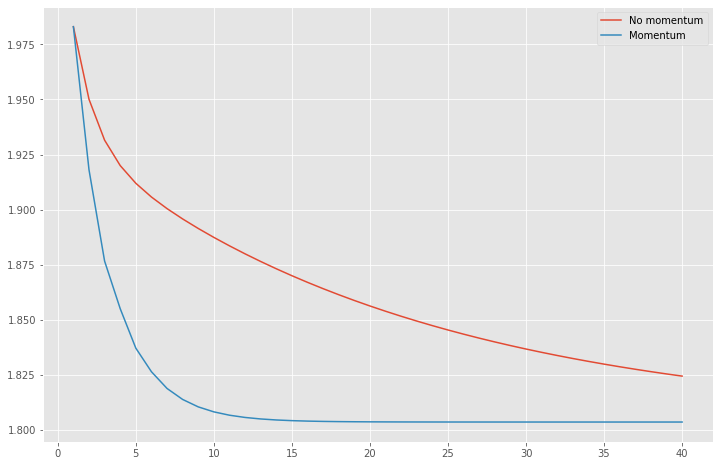

In [7]:
import matplotlib
import matplotlib.pyplot as plt

# configuration generale de matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('ggplot')

plt.figure()
plt.plot([i for i in range(1, len(val_nomomentum)+1)], val_nomomentum, label='No momentum')
plt.plot([i for i in range(1, len(val_momentum)+1)], val_momentum, label='Momentum')
plt.legend()
plt.show()

<span style="color:blue">**Question :**</span> **Comment expliquez-vous qu'un *momentum* bien configuré puisse accélérer l'optimisation ? Inspirez-vous de ce lien pour bien comprendre l'effet du *momentum* : [Animation momentum](https://distill.pub/2017/momentum/).**

## Le deep learning

N'hésitez pas à passer via [http://colab.research.google.com](http://colab.research.google.com) pour les exercices qui suivent.

D'extérieur complexe, le *deep learning* n'est en réalité qu'une composition et une combinaison linéaire de fonctions plus élémentaires comme celles que nous avons vu jusque là. Récupérons un jeu de données connu : $\texttt{CIFAR10}$.

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

In [9]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


L'objet $\texttt{transform}$ permettra de normaliser les données qui seront données à notre modèle. En $\texttt{pytorch}$, les données sont gérées par un *data loader*. En effet, on ne traite que très rarement tout le jeu de données d'un coup. On estime plutôt le gradient via un *batch* de données. De meilleurs résultats sont généralement observés lorsque le jeu de données est mélangé entre chaque itération d'optimisation. 

Regardons le jeu de données que nous sommes entrain de manipuler.

torch.Size([4, 3, 32, 32]) torch.Size([4])


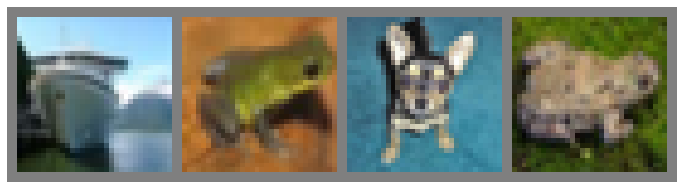

 ship	 frog	  dog	 frog


In [23]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('\t'.join('%5s' % classes[labels[j]] for j in range(4)))

Afin de faciliter la manipulation de notre réseau de neuronnes, il est d'usage de l'encapsuler dans une classe.

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

---
<span style="color:blue">**Exercice 1 :**</span> **Proposez le code permettant d'optimiser votre réseau pendant deux *epochs*.**

---

**** Finished Training ****


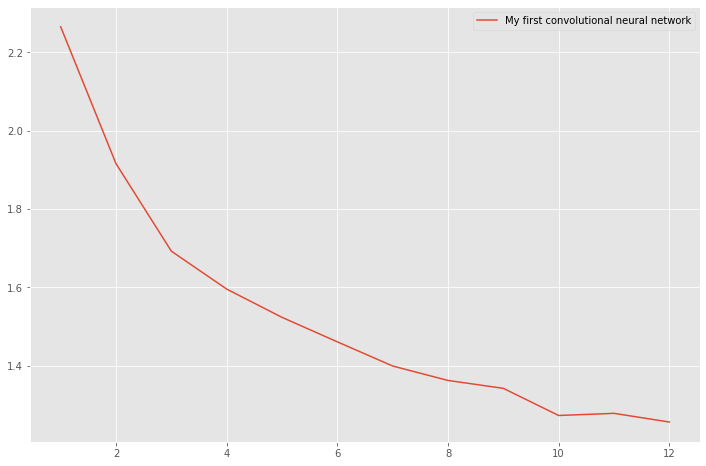

In [14]:
####### Complete this part ######## or die ####################
loss_history = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('\r[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000), end='')
            loss_history.append(running_loss / 2000)
            running_loss = 0.0
print('\r**** Finished Training ****')
plt.figure()
plt.plot([i for i in range(1, len(loss_history)+1)], loss_history, 
         label='My first convolutional neural network')
plt.legend()
plt.show()
###############################################################

In [24]:
torch.save(net.state_dict(), 'my_model.torch')

In [25]:
model = Net()
model.load_state_dict(torch.load('my_model.torch'))

<All keys matched successfully>

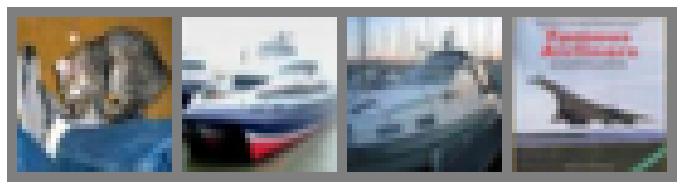

[Truth/prediction]:  [cat/cat] [ship/ship] [ship/ship] [plane/ship]


In [26]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = model(images)  # we use the loaded model
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print(
    '[Truth/prediction]: ', 
    ' '.join('[%s/%s]' % (classes[labels[j]], classes[predicted[j]]) for j in range(4))
)